# 一、指标选取和线性回归模型

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from textblob import TextBlob 
import matplotlib
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")
import random
import jieba
import re
from zhon.hanzi import punctuation
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.cluster.vq import vq,kmeans,whiten
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns


## 1. 读取数据

In [55]:
# 从⽂文件中读取原始数据
file_spread = '../数据集/债明细-生数据集.xlsx'           ###
df=pd.read_excel(file_spread)

## 2. 数据处理

In [56]:
# 按照指标分别删除0行
titles = ['ROE', 'ROA', 'ROS', 'ROIC', '总资产周转率','流动资产周转率','存货周转率','应收账款周转率','资产负债率','流动比率','速动比率','现金比率','利息保障倍数','销售收入增长率','净利润增长率','总资产增长率','经营活动现金流净额占比','投资活动现金流净额占比','筹资活动现金流净额占比','国内生产总值','居民消费价格指数增长率','一般预算收入','spread','scoring']
for t in titles:
    if t != '居民消费价格指数增长率':
        df = df[df[t]!=0]

# 存取筛选后的数据
ROE = df[titles[0]].values.tolist()   #盈利能力
ROA = df[titles[1]].values.tolist()
ROS = df[titles[2]].values.tolist() 
ROIC = df[titles[3]].values.tolist()

total_turnover = df[titles[4]].values.tolist()  #营运能力
flow_turnover = df[titles[5]].values.tolist()
inventory_turnover = df[titles[6]].values.tolist()
receive_turnover = df[titles[7]].values.tolist()

debt_r = df[titles[8]].values.tolist()   #负债情况
flow_r = df[titles[9]].values.tolist()
quick_r = df[titles[10]].values.tolist()
cash_r = df[titles[11]].values.tolist()
interest_mul = df[titles[12]].values.tolist()

sales = df[titles[13]].values.tolist()  #成长能力
profit = df[titles[14]].values.tolist()
assets = df[titles[15]].values.tolist()

business = df[titles[16]].values.tolist()   #现金流情况
invest = df[titles[17]].values.tolist()
finance = df[titles[18]].values.tolist() 

gdp = df[titles[19]].values.tolist()   #宏观
cpi = df[titles[20]].values.tolist()
budget = df[titles[21]].values.tolist()

# 列重命名
df.rename(columns={'总资产周转率':'TAT','流动资产周转率':'CAT','存货周转率':'ITR','应收账款周转率':'RTR', 
                   '资产负债率':'Debt','流动比率':'Flow','速动比率':'Quick','现金比率':'Cash','利息保障倍数':'Interest',
                   '销售收入增长率':'Sales','净利润增长率':'Profit','总资产增长率':'Assets',
                   '经营活动现金流净额占比':'Business','投资活动现金流净额占比':'Invest','筹资活动现金流净额占比':'Finance',
                   '国内生产总值':'GDP','居民消费价格指数增长率':'CPI','一般预算收入':'Budget'
                  }, inplace = True)

new_titles = ['ROE', 'ROA', 'ROS', 'ROIC', 'TAT','CAT','ITR','RTR','Debt','Flow','Quick','Cash','Interest','Sales','Profit','Assets','Business','Invest','Finance','GDP','CPI','Budget','spread','scoring']
new_titles2 = ['ROE', 'ROA', 'ROS', 'ROIC', 'TAT','CAT','ITR','RTR','Debt','Flow','Quick','Cash','Interest','Sales','Profit','Assets','Business','Invest','Finance','GDP','CPI','Budget','scoring','spread']

df.head()

债券简称                  发行人  发行规模  债券余额  发行期限  债券类型  票面利率(发行参考)  \
0        07宜城投债  安庆市城市建设投资发展(集团)有限公司   8.0   0.0  10.0   企业债        6.08   
1  15安庆城投MTN001  安庆市城市建设投资发展(集团)有限公司  10.0   0.0   5.0  中期票据        5.40   
2        15宜城投债  安庆市城市建设投资发展(集团)有限公司  16.0   6.4   7.0   企业债        6.01   
3   19安经开MTN001  安庆经济技术开发区建设投资集团有限公司   3.0   3.0   5.0  中期票据        6.30   
4       20皖江高科债      安庆皖江高科技投资发展有限公司   4.5   4.5   7.0   企业债        4.97   

        上市日期         起息日         到期日  ... 居民消费价格指数（上年＝100） Unnamed: 46  \
0 2007-12-13  2007-11-30  2017-11-30  ...        -0.001951         NaN   
1 2015-07-13  2015-07-10  2020-07-10  ...         0.006863         NaN   
2 2015-05-05  2015-04-27  2022-04-27  ...         0.008841         NaN   
3 2019-09-06  2019-09-05  2024-09-05  ...         0.008841         NaN   
4 2020-11-05  2020-11-03  2027-11-03  ...         0.008841         NaN   

  Unnamed: 47  Unnamed: 48  Unnamed: 49 Unnamed: 50   spread平均值  Unnamed: 52  \
0         NaN          吉林省   12408892.0         NaN     1.92983          NaN   
1         NaN          浙江省   65982120.0         NaN      ROE平均值          NaN   
2         NaN      广西壮族自治区   16814466.0         NaN     2.09906          NaN   
3         NaN          陕西省   22431391.0         NaN  scoring平均值          NaN   
4         NaN          山西省   22926982.0         NaN     18.6077          NaN   

   Unnamed: 53  Unnamed: 54  
0          NaN          NaN  
1          NaN          NaN  
2          NaN          NaN  
3          NaN          NaN  
4          NaN          NaN  

[5 rows x 55 columns]

## 3. 多指标相关性分析

In [57]:
# 将所有指标分别相互相关性分析
data_corr = df[new_titles]
data_corr = pd.DataFrame(data_corr, dtype=np.float)
sp_corr = data_corr.corr(method='spearman')
sp_corr

# 将相关性检测结果输出到结果集
sp_corr.to_excel("../数据集/results/correlation.xlsx",index=0)

In [58]:
# 检查缺失值
print(np.isnan(data_corr).any())

ROE         False
ROA         False
ROS         False
ROIC        False
TAT         False
CAT         False
ITR         False
RTR         False
Debt        False
Flow        False
Quick       False
Cash        False
Interest    False
Sales       False
Profit      False
Assets      False
Business    False
Invest      False
Finance     False
GDP         False
CPI         False
Budget      False
spread      False
scoring     False
dtype: bool


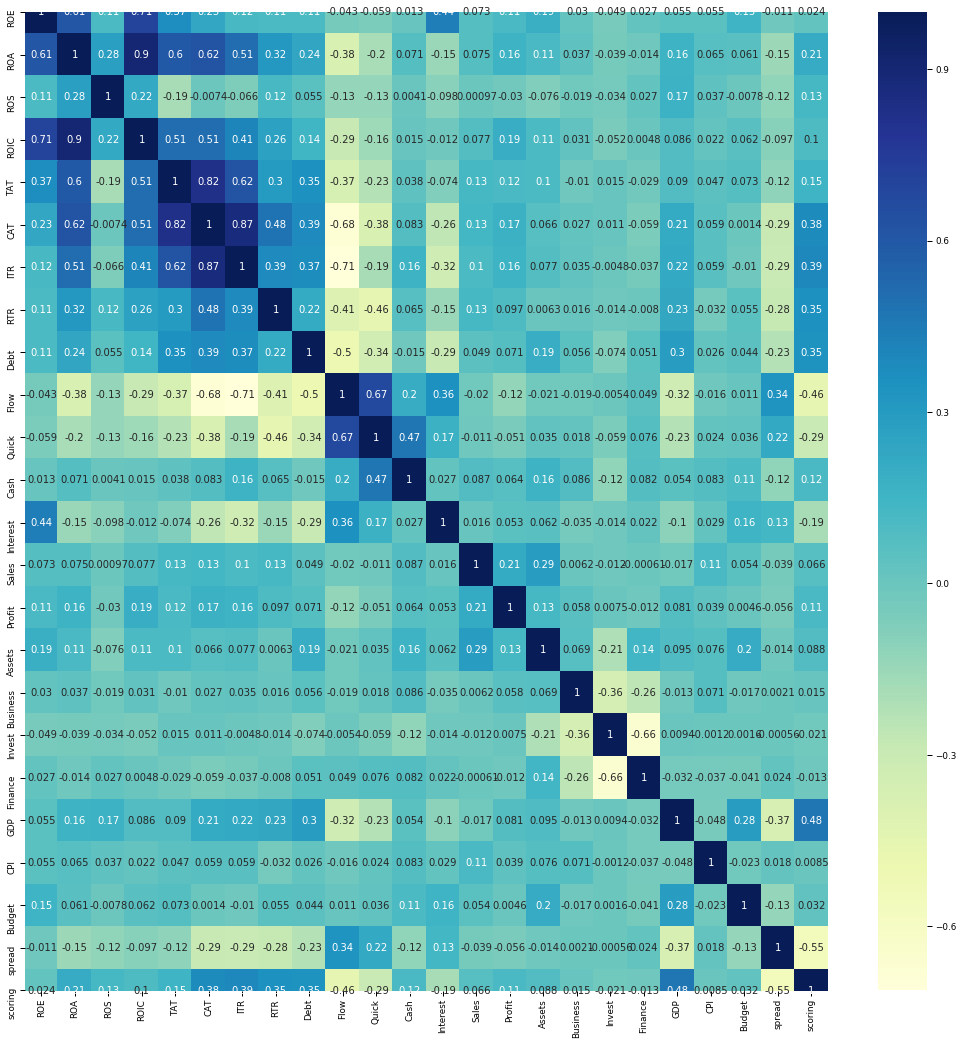

In [59]:
# 相关性热力图
fig = plt.figure(figsize=(18,18))
sns.heatmap(sp_corr, cmap="YlGnBu", annot=True)
plt.savefig("../数据集/results/Factors_heatmap.jpg")

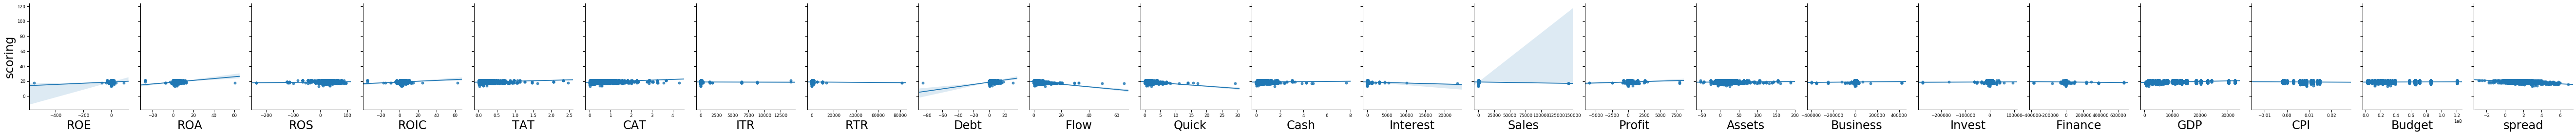

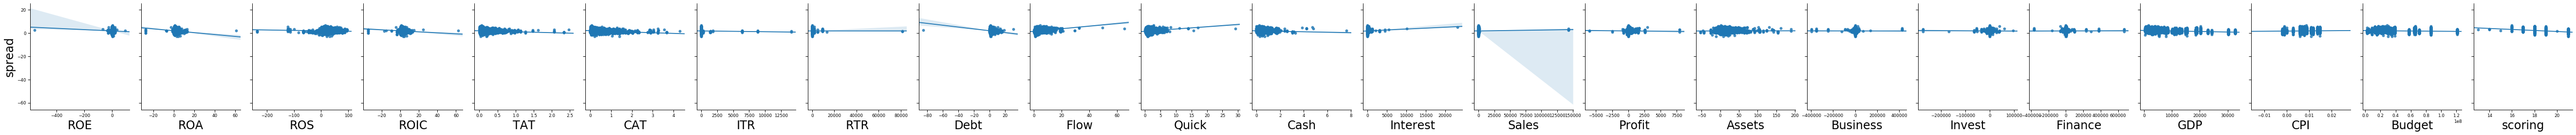

In [60]:
# 分别绘制【scoring与各指标】、【spread与各指标】的回归图
sns.pairplot(data_corr, x_vars=['ROE', 'ROA', 'ROS', 'ROIC', 'TAT','CAT','ITR','RTR','Debt','Flow','Quick','Cash','Interest','Sales','Profit','Assets','Business','Invest','Finance','GDP','CPI','Budget','spread'], y_vars='scoring', size=4, aspect=0.8,kind = 'reg')
sns.set_context("paper", rc={"axes.labelsize":24})
plt.savefig("../数据集/results/Factors_pairplot_scoring.jpg")

sns.pairplot(data_corr, x_vars=['ROE', 'ROA', 'ROS', 'ROIC', 'TAT','CAT','ITR','RTR','Debt','Flow','Quick','Cash','Interest','Sales','Profit','Assets','Business','Invest','Finance','GDP','CPI','Budget','scoring'], y_vars='spread', size=4, aspect=0.8,kind = 'reg')
sns.set_context("paper", rc={"axes.labelsize":24})
plt.savefig("../数据集/results/Factors_pairplot_spread.jpg")
plt.show()

## 4. 线性回归模型与评价

### (1) Candidate Factor Set对照组 - From Shenwanhongyuan

0. 传统的模型
原始数据特征: (7155, 11) ,训练数据特征: (5008, 10) ,测试数据特征: (2147, 10)
原始数据标签: (7155,) ,训练数据标签: (5008,) ,测试数据标签: (2147,)
最佳拟合线:截距 18.912250664564137
回归系数： [ 4.92170162e-02  1.31079196e-05  9.32788811e-02 -1.01599334e-04
  7.23283606e-02 -1.90793018e-01  7.13979453e-01 -8.50303487e-05
  6.86114883e-08 -4.44813234e-09]
--ShenWanHongYuan Agency的模型评价--
0.19050812983152687
[18.73730191 18.40955368 18.71233446 ... 19.83910884 19.45640353
 19.44911255]


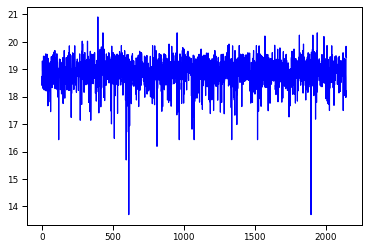

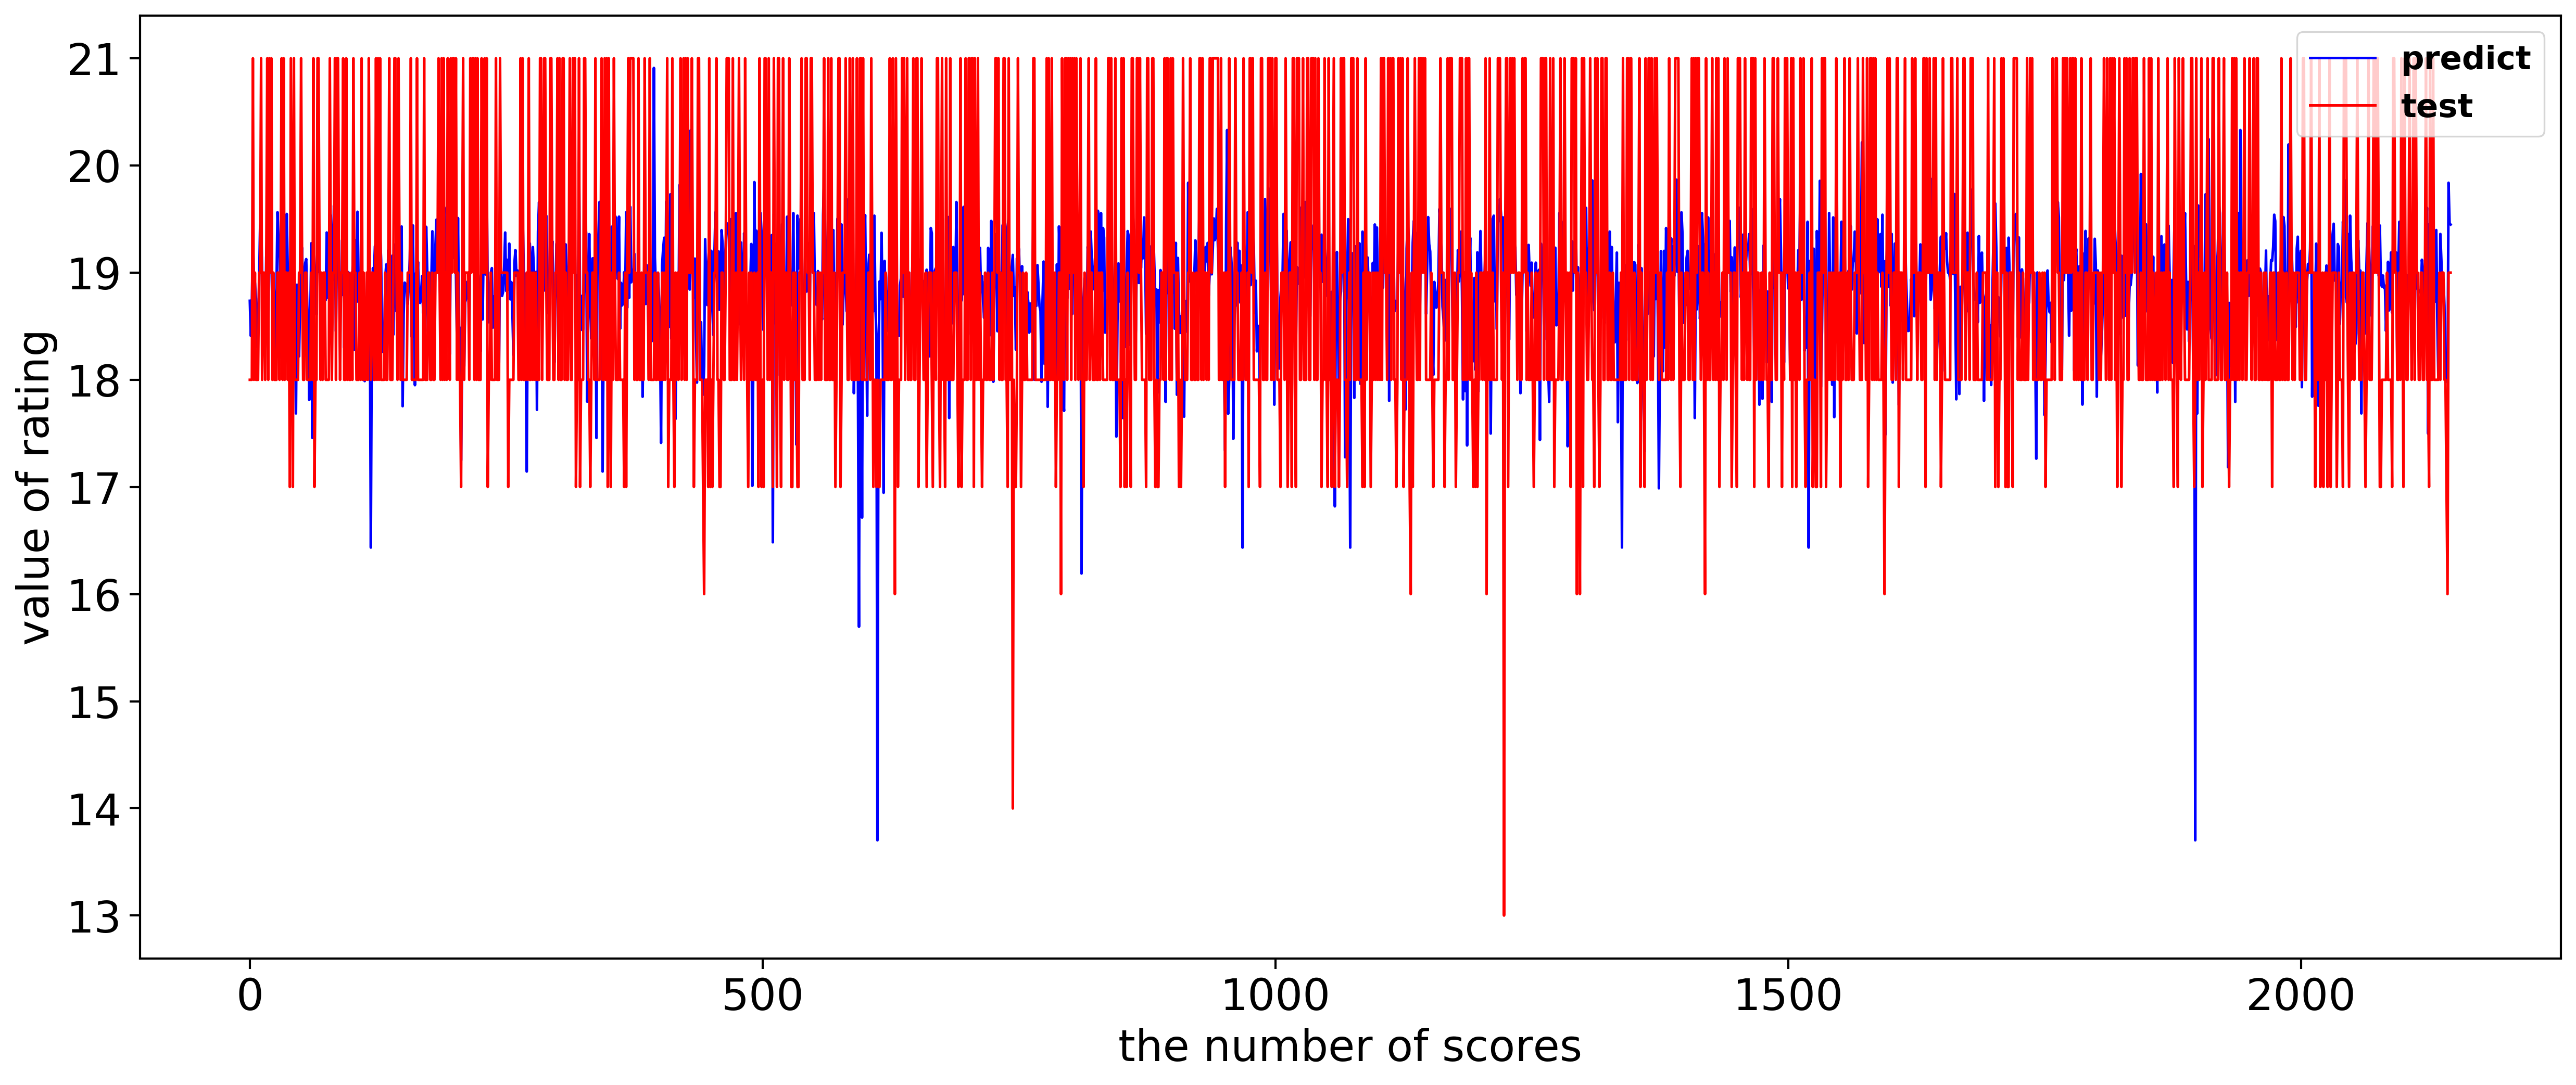

<Figure size 432x288 with 0 Axes>

In [61]:
# 别人的模型作为对照

print("0. 传统的模型")
# 创建一个corr
ori_titles = ['ROA','RTR','TAT','ITR','Debt','Flow','Cash','Interest','Business','Invest','scoring']
data_corr0 = df[ori_titles]
data_corr0 = pd.DataFrame(data_corr0, dtype=np.float)

X_train,X_test,Y_train,Y_test = train_test_split(data_corr0.ix[:,:10],data_corr0.scoring,train_size=.7)
 
print("原始数据特征:",data_corr0.ix[:,:11].shape,
      ",训练数据特征:",X_train.shape,
      ",测试数据特征:",X_test.shape)
 
print("原始数据标签:",data_corr0.scoring.shape,
      ",训练数据标签:",Y_train.shape,
      ",测试数据标签:",Y_test.shape)

# 建立初步的数据集模型之后将训练集中的特征值与标签值放入LinearRegression()模型中且使用fit函数进行训练
# 在模型训练完成之后会得到所对应的方程式（线性回归方程式）需要利用函数中的intercept_与coef_。
model_0 = LinearRegression()
model_0.fit(X_train,Y_train)
a0  = model_0.intercept_         #截距
b0  = model_0.coef_              #回归系数
print("最佳拟合线:截距",a0)
print("回归系数：",b0)

# 4. 指标选取以后的模型评价
print("--ShenWanHongYuan Agency的模型评价--")
score_0 = model_0.score(X_test,Y_test)
print(score_0)
 
#对线性回归进行预测
Y_pred = model_0.predict(X_test)
print(Y_pred)
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.show()

# 线性回归预测与测试对比
plt.figure(dpi=300,figsize=(20,8))
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_pred)),Y_test,'r',label="test")
plt.legend(loc="upper right", prop={"size":15,"weight":"black"}) #显示图中的标签
plt.tick_params(labelsize=20)  # 放大坐标轴刻度
plt.xlabel("the number of scores", fontsize=20)
plt.ylabel('value of rating', fontsize=20)
plt.show()
plt.savefig("../数据集/results/linear_regression_one.jpg")

### (2) 包含23个因子集的Candidate Factor Set 

0-2 我的传统线性模型
原始数据特征: (7155, 22) ,训练数据特征: (5008, 22) ,测试数据特征: (2147, 22)
原始数据标签: (7155,) ,训练数据标签: (5008,) ,测试数据标签: (2147,)
最佳拟合线:截距 18.301195109926688
回归系数： [-1.16378198e-02  1.57999663e-01 -2.14590543e-03 -1.19647388e-01
 -1.46808927e+00  8.48831513e-01 -6.96753463e-05  5.61636397e-07
  7.61956013e-02 -8.94262088e-02 -7.28081434e-02  5.23289915e-01
 -6.65078597e-05 -7.43298151e-06  1.23632823e-04  3.04683314e-03
  1.09791029e-06 -1.70995668e-06  6.11683408e-07  5.74409603e-05
  5.92253024e+00 -2.82714098e-09]
--Candidate Set模型评价--
0.3288022405770193
[17.9787605  18.23701812 18.06410072 ... 19.2121819  18.44456361
 19.23183117]


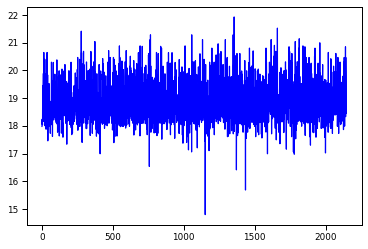

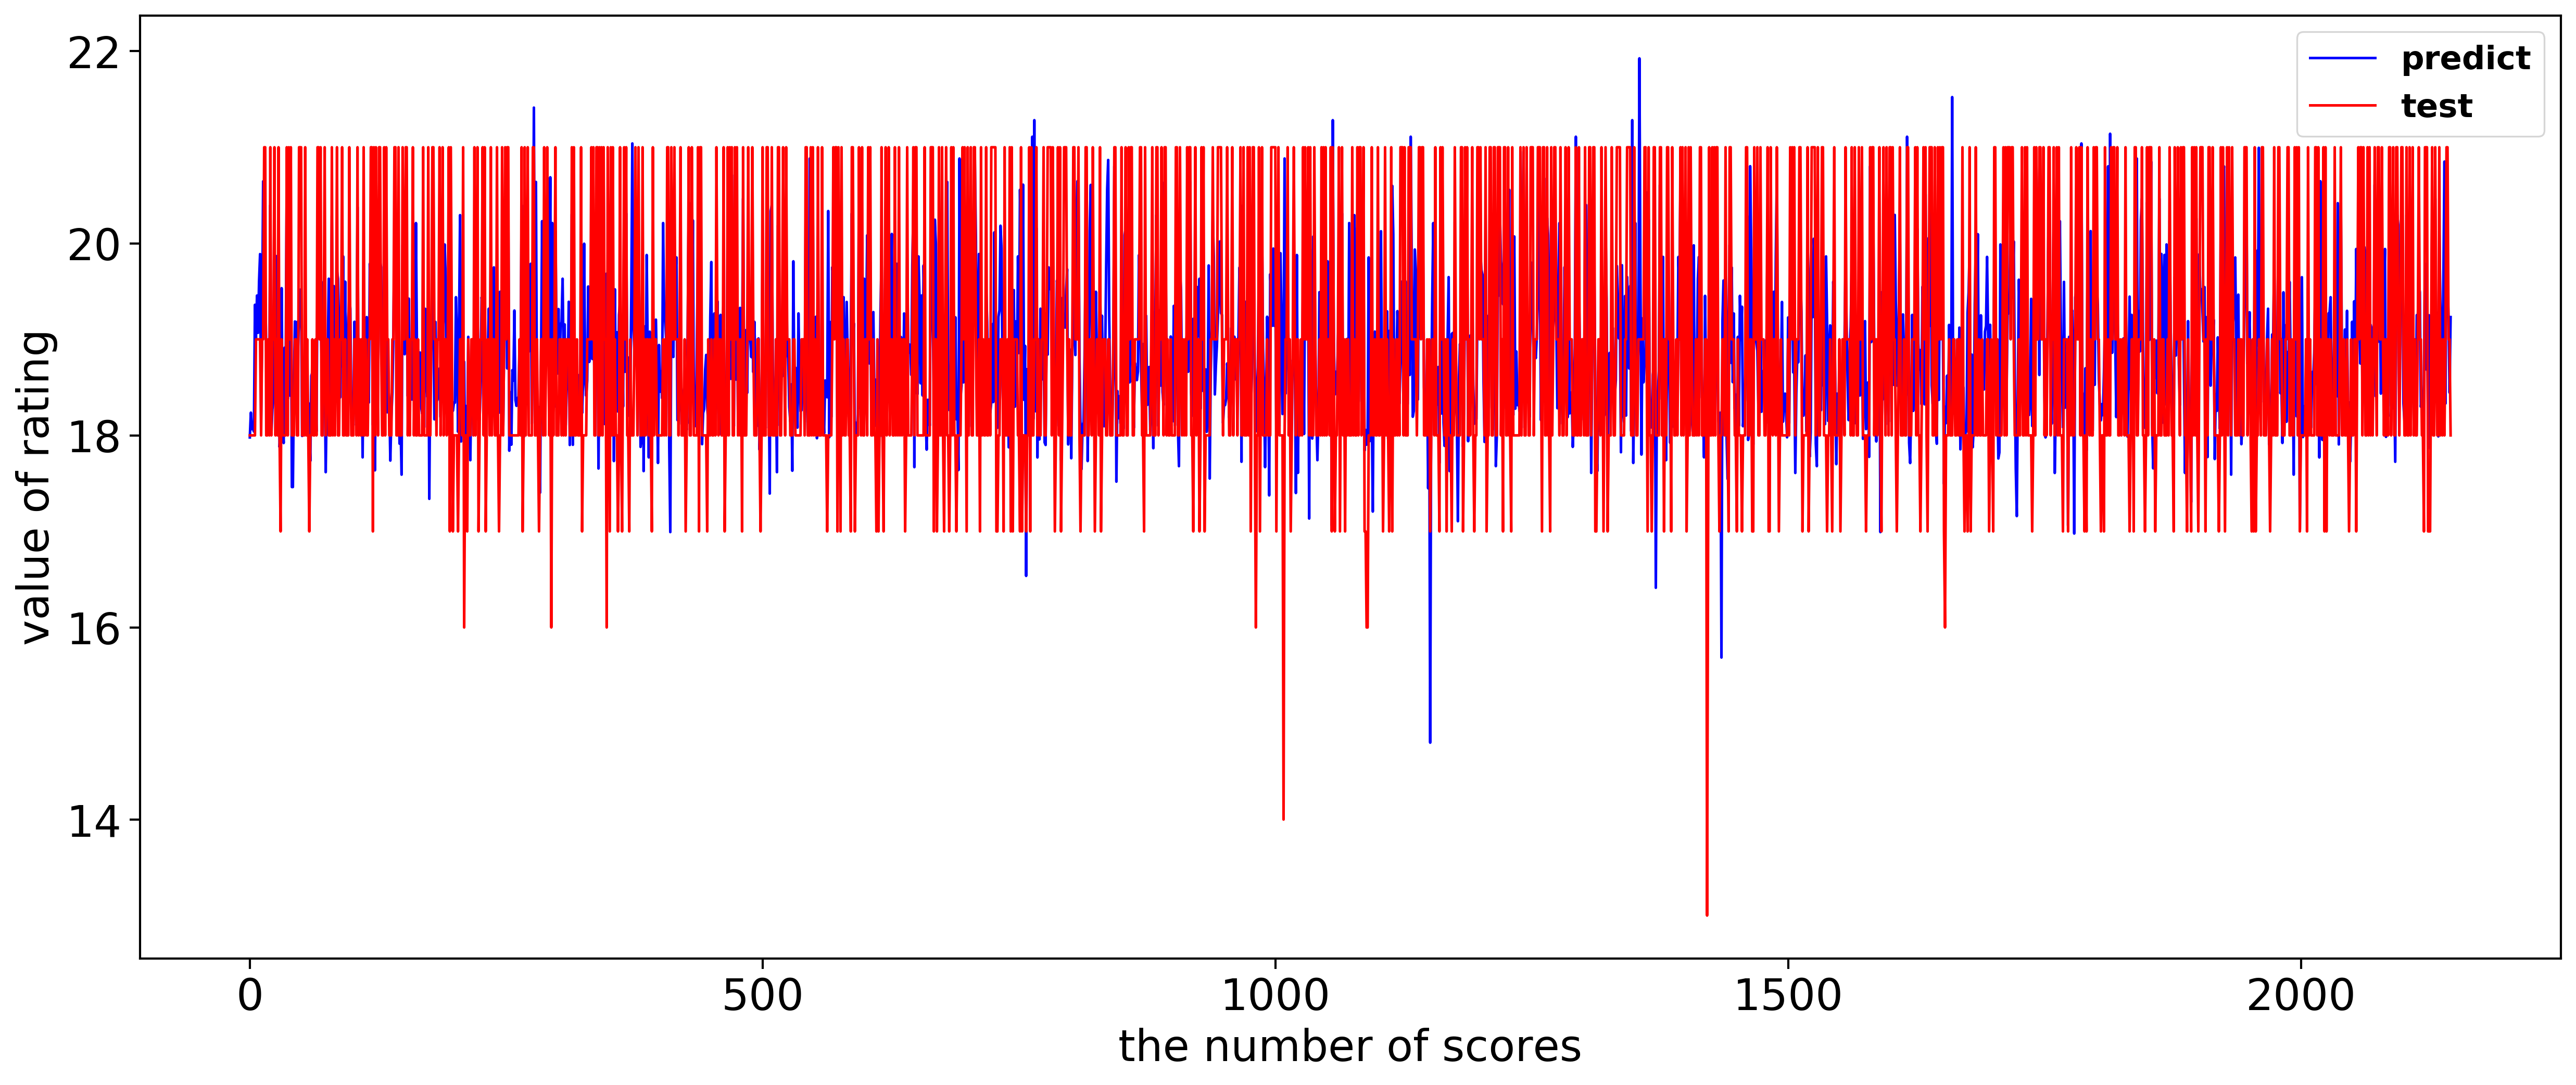

In [62]:
# 1. 我的传统线性模型

print("0-2 我的传统线性模型")
X_train,X_test,Y_train,Y_test = train_test_split(data_corr.ix[:,:22],data_corr.scoring,train_size=.7)
 
print("原始数据特征:",data_corr.ix[:,:22].shape,
      ",训练数据特征:",X_train.shape,
      ",测试数据特征:",X_test.shape)
 
print("原始数据标签:",data_corr.scoring.shape,
      ",训练数据标签:",Y_train.shape,
      ",测试数据标签:",Y_test.shape)

# 建立初步的数据集模型之后将训练集中的特征值与标签值放入LinearRegression()模型中且使用fit函数进行训练
# 在模型训练完成之后会得到所对应的方程式（线性回归方程式）需要利用函数中的intercept_与coef_。
model = LinearRegression()
model.fit(X_train,Y_train)
a  = model.intercept_        #截距
b = model.coef_              #回归系数
print("最佳拟合线:截距",a)
print("回归系数：",b)

# 2. 评价模型
print("--Candidate Set模型评价--")
score = model.score(X_test,Y_test)
print(score)
 
#对线性回归进行预测
Y_pred = model.predict(X_test)
print(Y_pred)
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.show()

# 线性回归预测与测试对比
plt.figure(dpi=300,figsize=(20,8))
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_pred)),Y_test,'r',label="test")
plt.legend(loc='upper right', prop={"size":15,"weight":"black"}) # 显示图例
plt.tick_params(labelsize=20)  # 放大坐标轴刻度
plt.xlabel("the number of scores", fontsize=20)
plt.ylabel('value of rating', fontsize=20)
plt.show
plt.savefig("../数据集/results/linear_regression_two.jpg")

### （3）24个Candidate Factor Set（包含Credit Spread）

1. scoring的线性模型
原始数据特征: (7155, 23) ,训练数据特征: (5008, 23) ,测试数据特征: (2147, 23)
原始数据标签: (7155,) ,训练数据标签: (5008,) ,测试数据标签: (2147,)
最佳拟合线:截距 19.19931452811069
回归系数： [-9.86579147e-03  1.24527381e-01 -2.05265673e-03 -1.02677477e-01
 -1.13672341e+00  6.14893679e-01 -9.23127641e-05 -4.13973879e-06
  5.97061239e-02 -7.54939926e-02 -6.62467001e-02  4.10370678e-01
 -5.36411767e-05 -6.85139220e-06  1.34981262e-04  3.01015312e-03
  1.81005314e-06 -2.52364767e-06  7.13756275e-07  4.16692375e-05
  8.71282916e+00 -3.15668451e-09 -3.59717200e-01]
--Spread involved模型评价--
0.46145861861542975
[17.44146208 19.03026722 18.63035731 ... 19.91096399 18.95291783
 18.85534691]


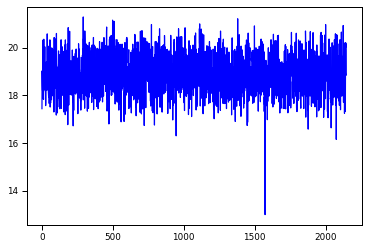

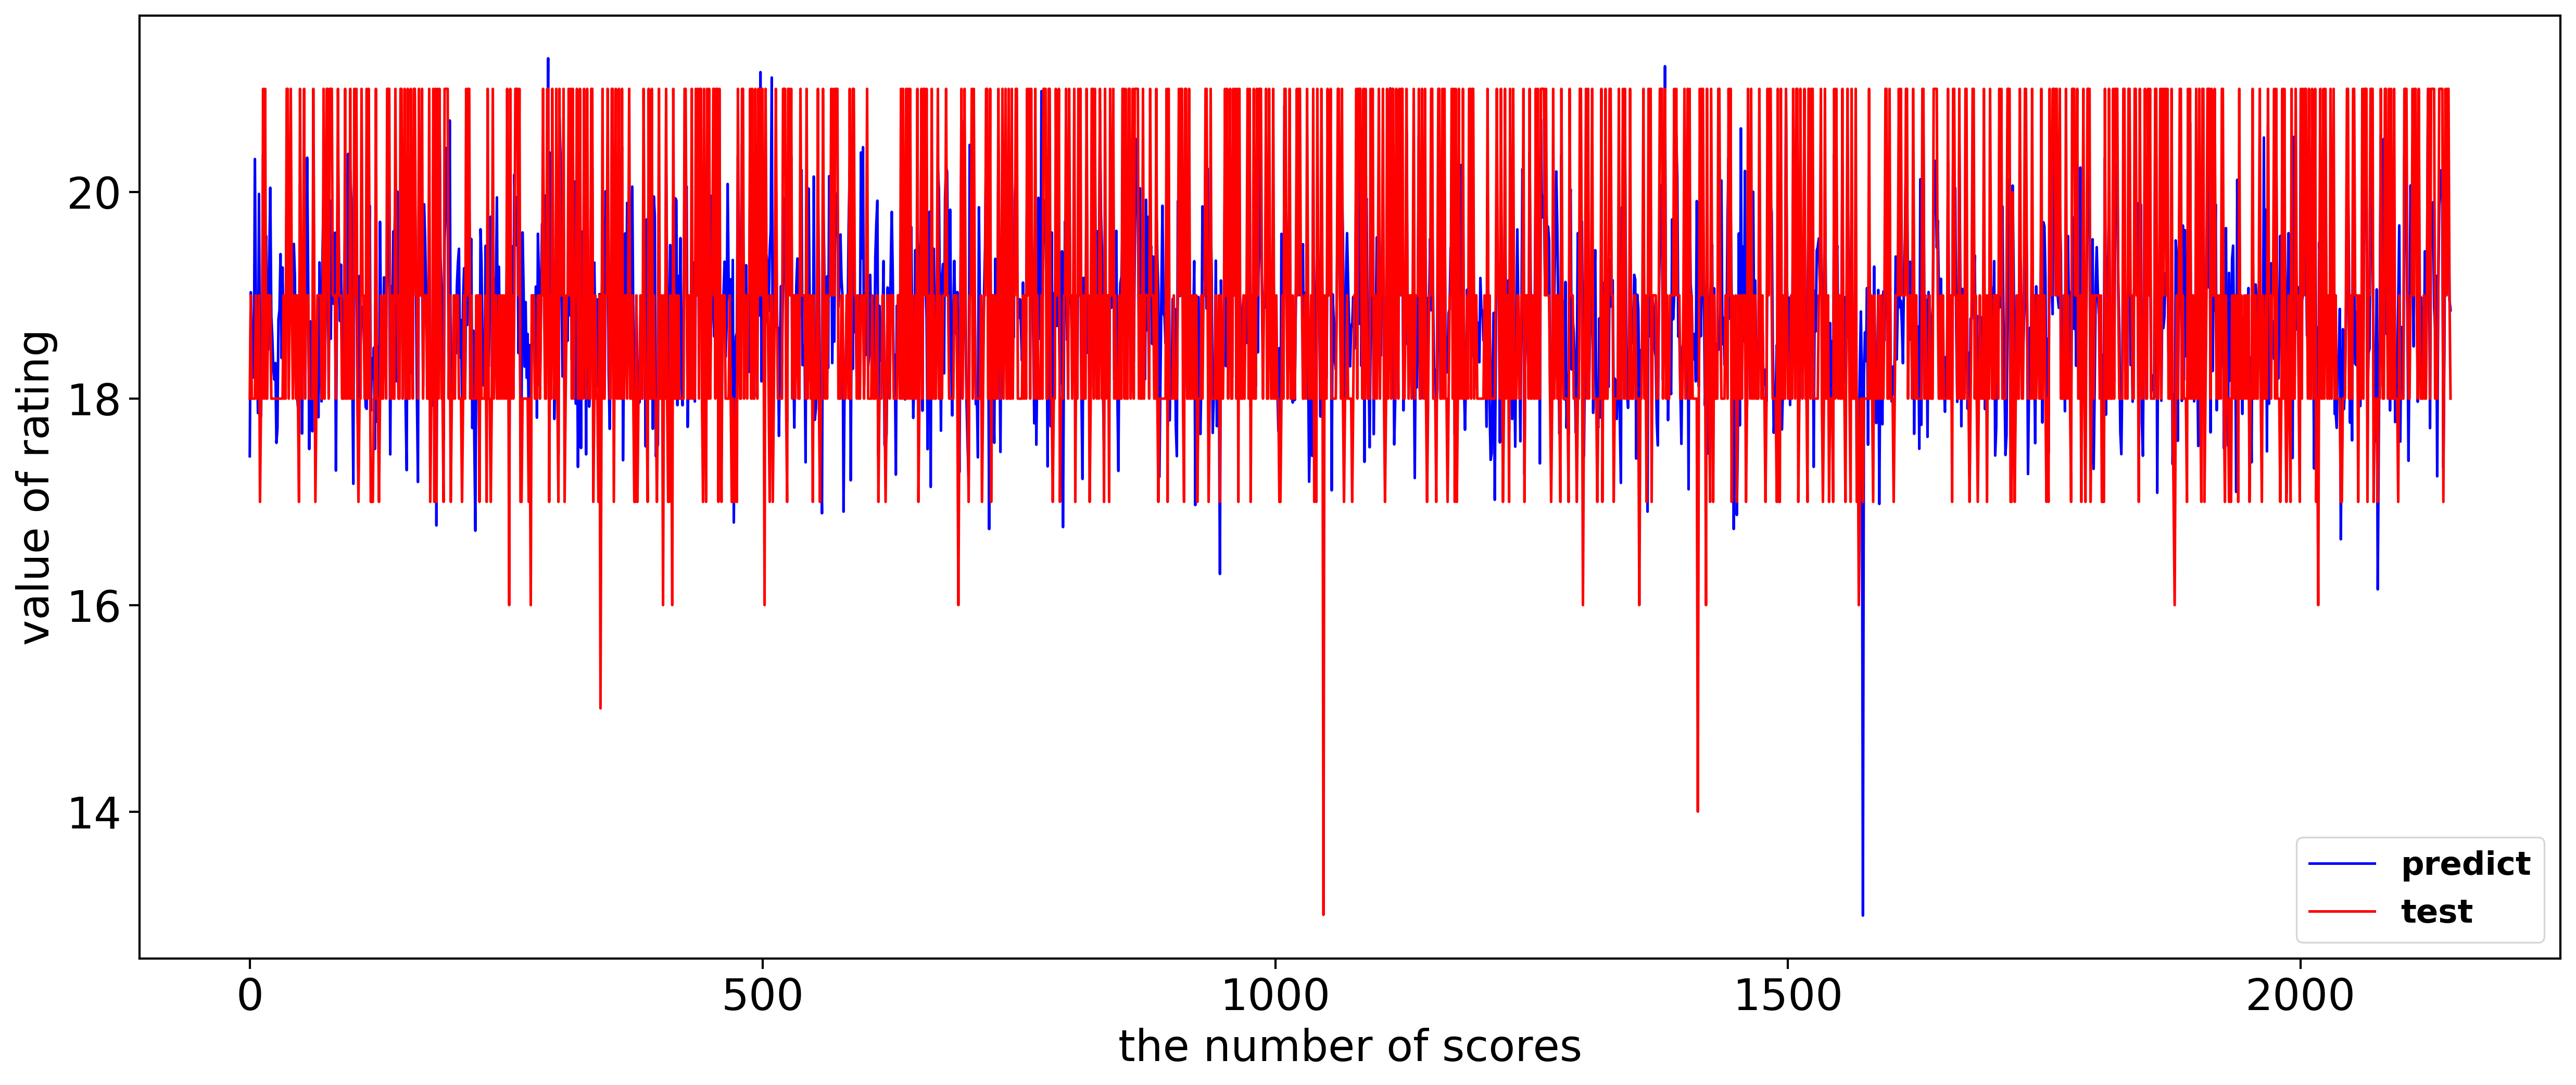

<Figure size 432x288 with 0 Axes>

In [63]:
# 1. scoring的线性模型
# 回归方程 y = a + b*x (模型建立最佳拟合线)
# 点误差 = 实际值 - 拟合值
# 误差平方和（Sum of square error） SSE = Σ（实际值-预测值）^2
# 最小二乘法 ： 使得误差平方和最小（最佳拟合）

print("1. scoring的线性模型")
X_train,X_test,Y_train,Y_test = train_test_split(data_corr.ix[:,:23],data_corr.scoring,train_size=.7)
 
print("原始数据特征:",data_corr.ix[:,:23].shape,
      ",训练数据特征:",X_train.shape,
      ",测试数据特征:",X_test.shape)
 
print("原始数据标签:",data_corr.scoring.shape,
      ",训练数据标签:",Y_train.shape,
      ",测试数据标签:",Y_test.shape)

# 建立初步的数据集模型之后将训练集中的特征值与标签值放入LinearRegression()模型中且使用fit函数进行训练
# 在模型训练完成之后会得到所对应的方程式（线性回归方程式）需要利用函数中的intercept_与coef_。
model = LinearRegression()
model.fit(X_train,Y_train)
a  = model.intercept_        #截距
b = model.coef_              #回归系数
print("最佳拟合线:截距",a)
print("回归系数：",b)

# 2. 评价模型
print("--Spread involved模型评价--")
score = model.score(X_test,Y_test)
print(score)
 
#对线性回归进行预测
Y_pred = model.predict(X_test)
print(Y_pred)
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.show()

# 线性回归预测与测试对比
plt.figure(dpi=300,figsize=(20,8))
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_pred)),Y_test,'r',label="test")
plt.legend(loc='lower right', prop={"size":15,"weight":"black"}) # 显示图例
plt.tick_params(labelsize=20)  # 放大坐标轴刻度
plt.xlabel("the number of scores", fontsize=20)
plt.ylabel('value of rating', fontsize=20)
plt.show()
plt.savefig("../数据集/results/linear_regression_three.jpg")

### （4）以Credit Spread的标准的Candidate Factor Set 

2. spread的线性模型
原始数据特征: (7155, 23) ,训练数据特征: (5008, 23) ,测试数据特征: (2147, 23)
原始数据标签: (7155,) ,训练数据标签: (5008,) ,测试数据标签: (2147,)
最佳拟合线:截距 8.248592735273732
回归系数： [ 1.30475093e-03 -8.65122412e-03 -1.07838917e-03  7.86800066e-03
  5.46190434e-02 -1.66417092e-01 -4.54221769e-05 -5.34487853e-06
  7.62044737e-03  3.10857787e-02  7.54488058e-02 -4.26722487e-01
  8.22015136e-05  2.18431274e-06  8.73193454e-05  2.91326829e-03
  4.72769933e-07 -7.47944269e-07  2.75061992e-07 -1.46045734e-05
  5.78879007e+00 -3.42127379e-09 -3.24716519e-01]
--spread模型评价--
0.29836846481818946
[2.37075824 0.72454025 1.2328458  ... 0.62425239 2.18323028 2.35432571]


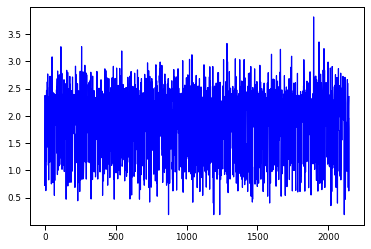

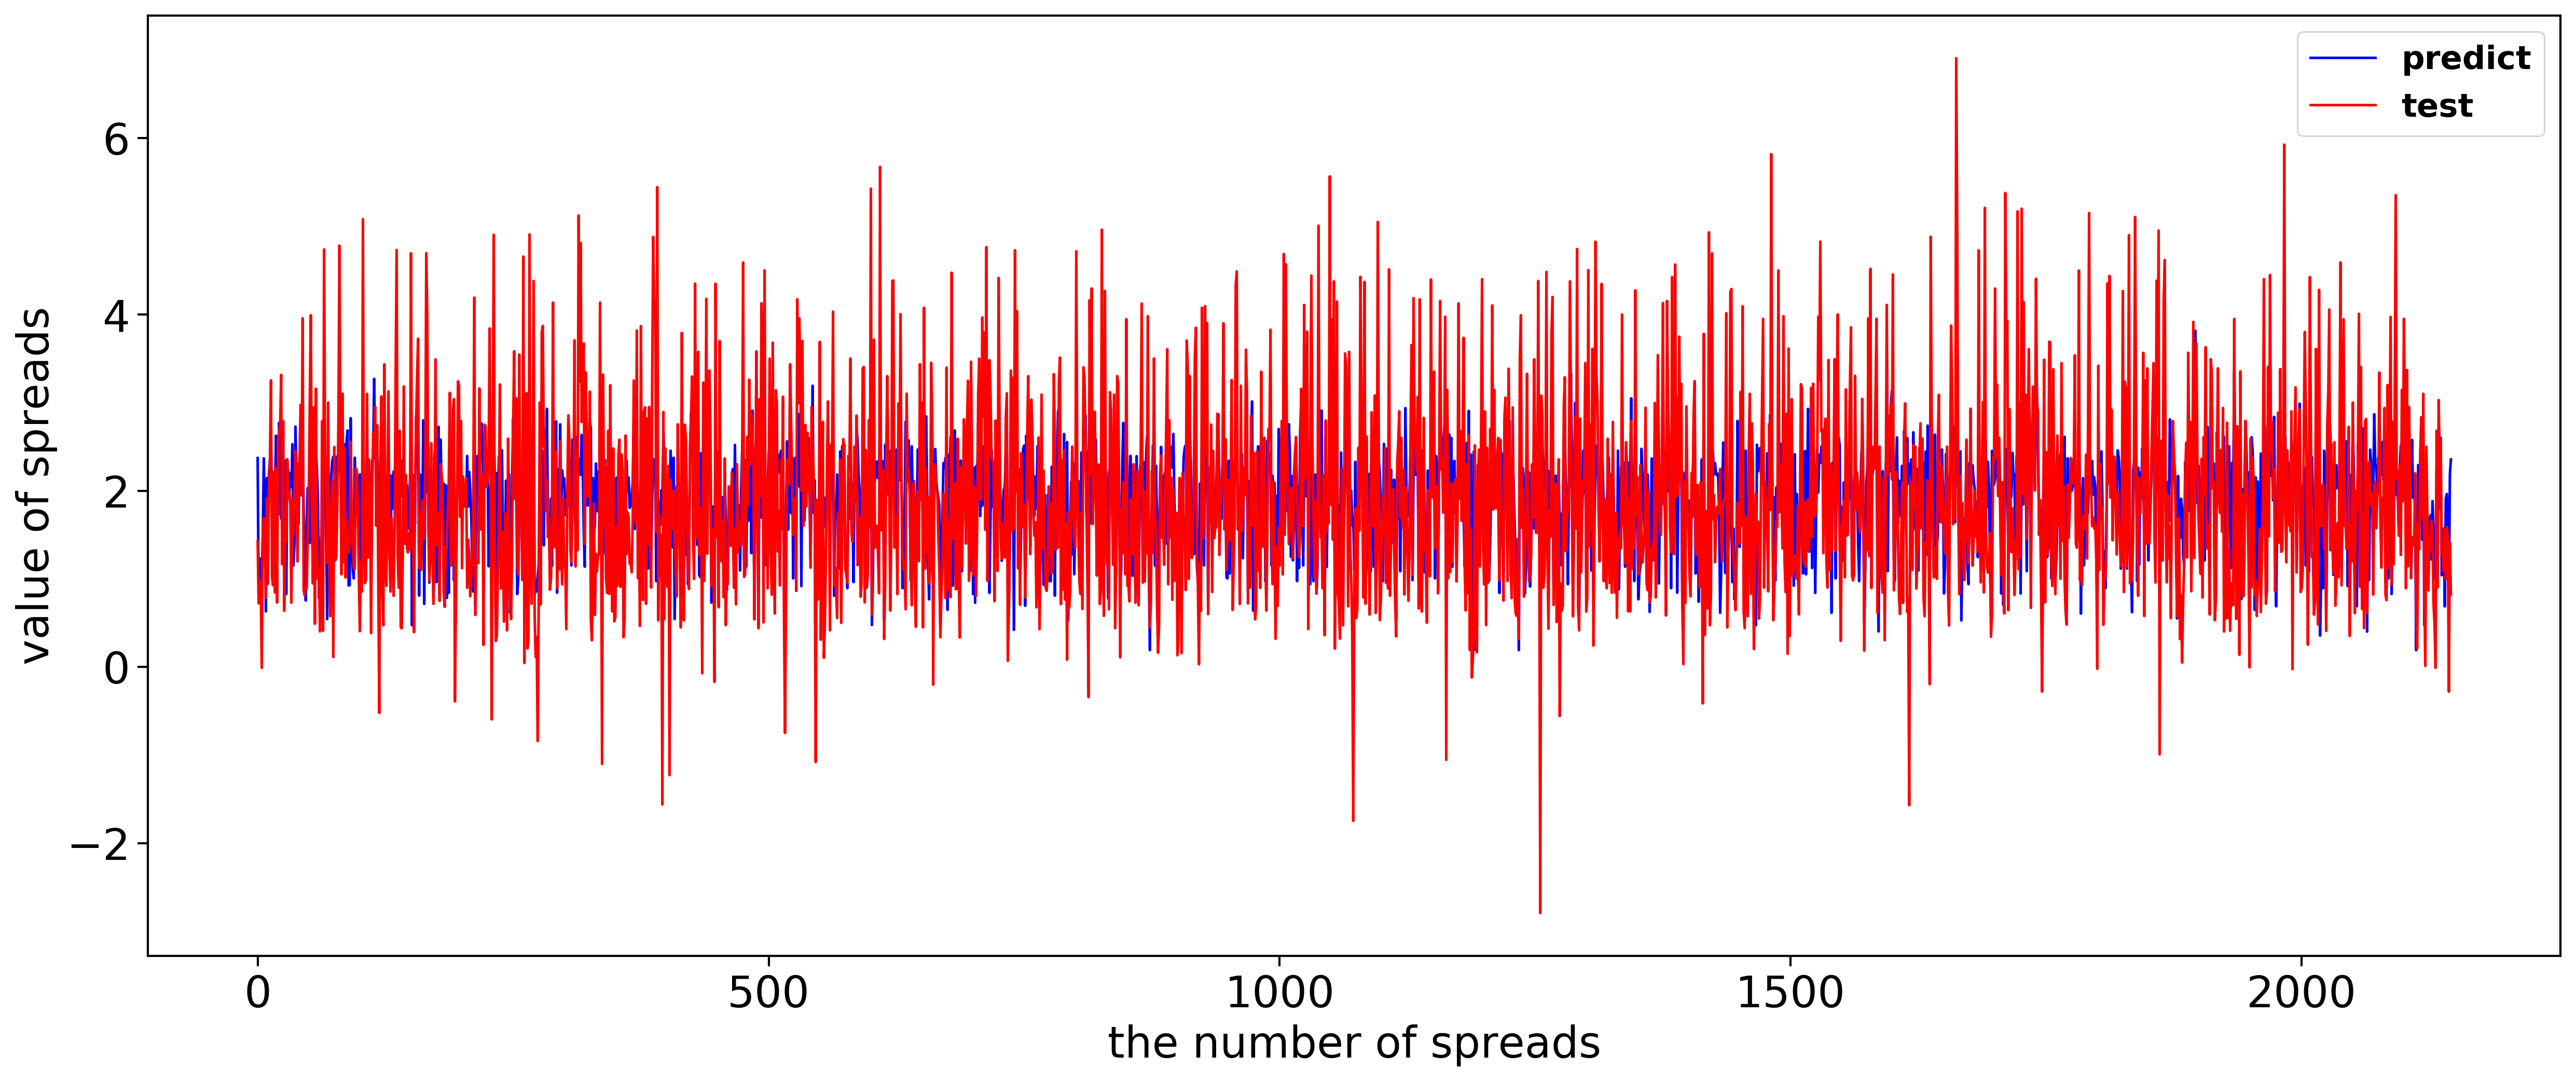

<Figure size 432x288 with 0 Axes>

In [64]:
# 3. spread线性回归模型

print("2. spread的线性模型")
# 为spread创建一个corr
data_corr2 = df[new_titles2]
data_corr2 = pd.DataFrame(data_corr2, dtype=np.float)

X_train,X_test,Y_train,Y_test = train_test_split(data_corr2.ix[:,:23],data_corr2.spread,train_size=.7)
 
print("原始数据特征:",data_corr2.ix[:,:23].shape,
      ",训练数据特征:",X_train.shape,
      ",测试数据特征:",X_test.shape)
 
print("原始数据标签:",data_corr2.spread.shape,
      ",训练数据标签:",Y_train.shape,
      ",测试数据标签:",Y_test.shape)

# 建立初步的数据集模型之后将训练集中的特征值与标签值放入LinearRegression()模型中且使用fit函数进行训练
# 在模型训练完成之后会得到所对应的方程式（线性回归方程式）需要利用函数中的intercept_与coef_。
model_s = LinearRegression()
model_s.fit(X_train,Y_train)
a2  = model_s.intercept_        #截距
b2  = model_s.coef_              #回归系数
print("最佳拟合线:截距",a2)
print("回归系数：",b2)

# 4. spread模型评价
print("--spread模型评价--")
score_s = model_s.score(X_test,Y_test)
print(score_s)
 
#对线性回归进行预测
Y_pred = model_s.predict(X_test)
print(Y_pred)
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.show()

# 线性回归预测与测试对比
plt.figure(dpi=300,figsize=(20,8))
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_pred)),Y_test,'r',label="test")
plt.legend(loc='upper right', prop={"size":15,"weight":"black"}) # 显示图例
plt.tick_params(labelsize=20)  # 放大坐标轴刻度
plt.xlabel("the number of spreads", fontsize=20)
plt.ylabel('value of spreads', fontsize=20)
plt.show()
plt.savefig("../数据集/results/linear_regression_four.jpg")

## 5. 指标选取与评价

### （5）根据相关性筛选后的Candidate Factor Set 

3. 指标选取一的线性模型
原始数据特征: (7155, 16) ,训练数据特征: (5008, 16) ,测试数据特征: (2147, 16)
原始数据标签: (7155,) ,训练数据标签: (5008,) ,测试数据标签: (2147,)
最佳拟合线:截距 19.29789878590993
回归系数： [ 1.50588079e-01 -2.70623813e-03 -1.04562814e-01 -1.12785973e+00
  6.27233228e-01 -8.33529420e-05  5.44281743e-07  2.98945639e-02
 -7.55572755e-02 -4.82306996e-02  3.75806532e-01 -1.93609462e-05
  1.40101889e-04  4.36797346e-05 -2.98237969e-09 -3.70144600e-01]
--Selected Factors模型评价--
0.4155233669199242
[18.66533626 19.20423688 18.23976412 ... 18.12050808 18.7536127
 18.15906963]


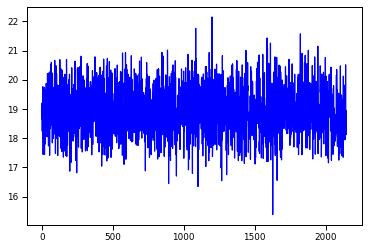

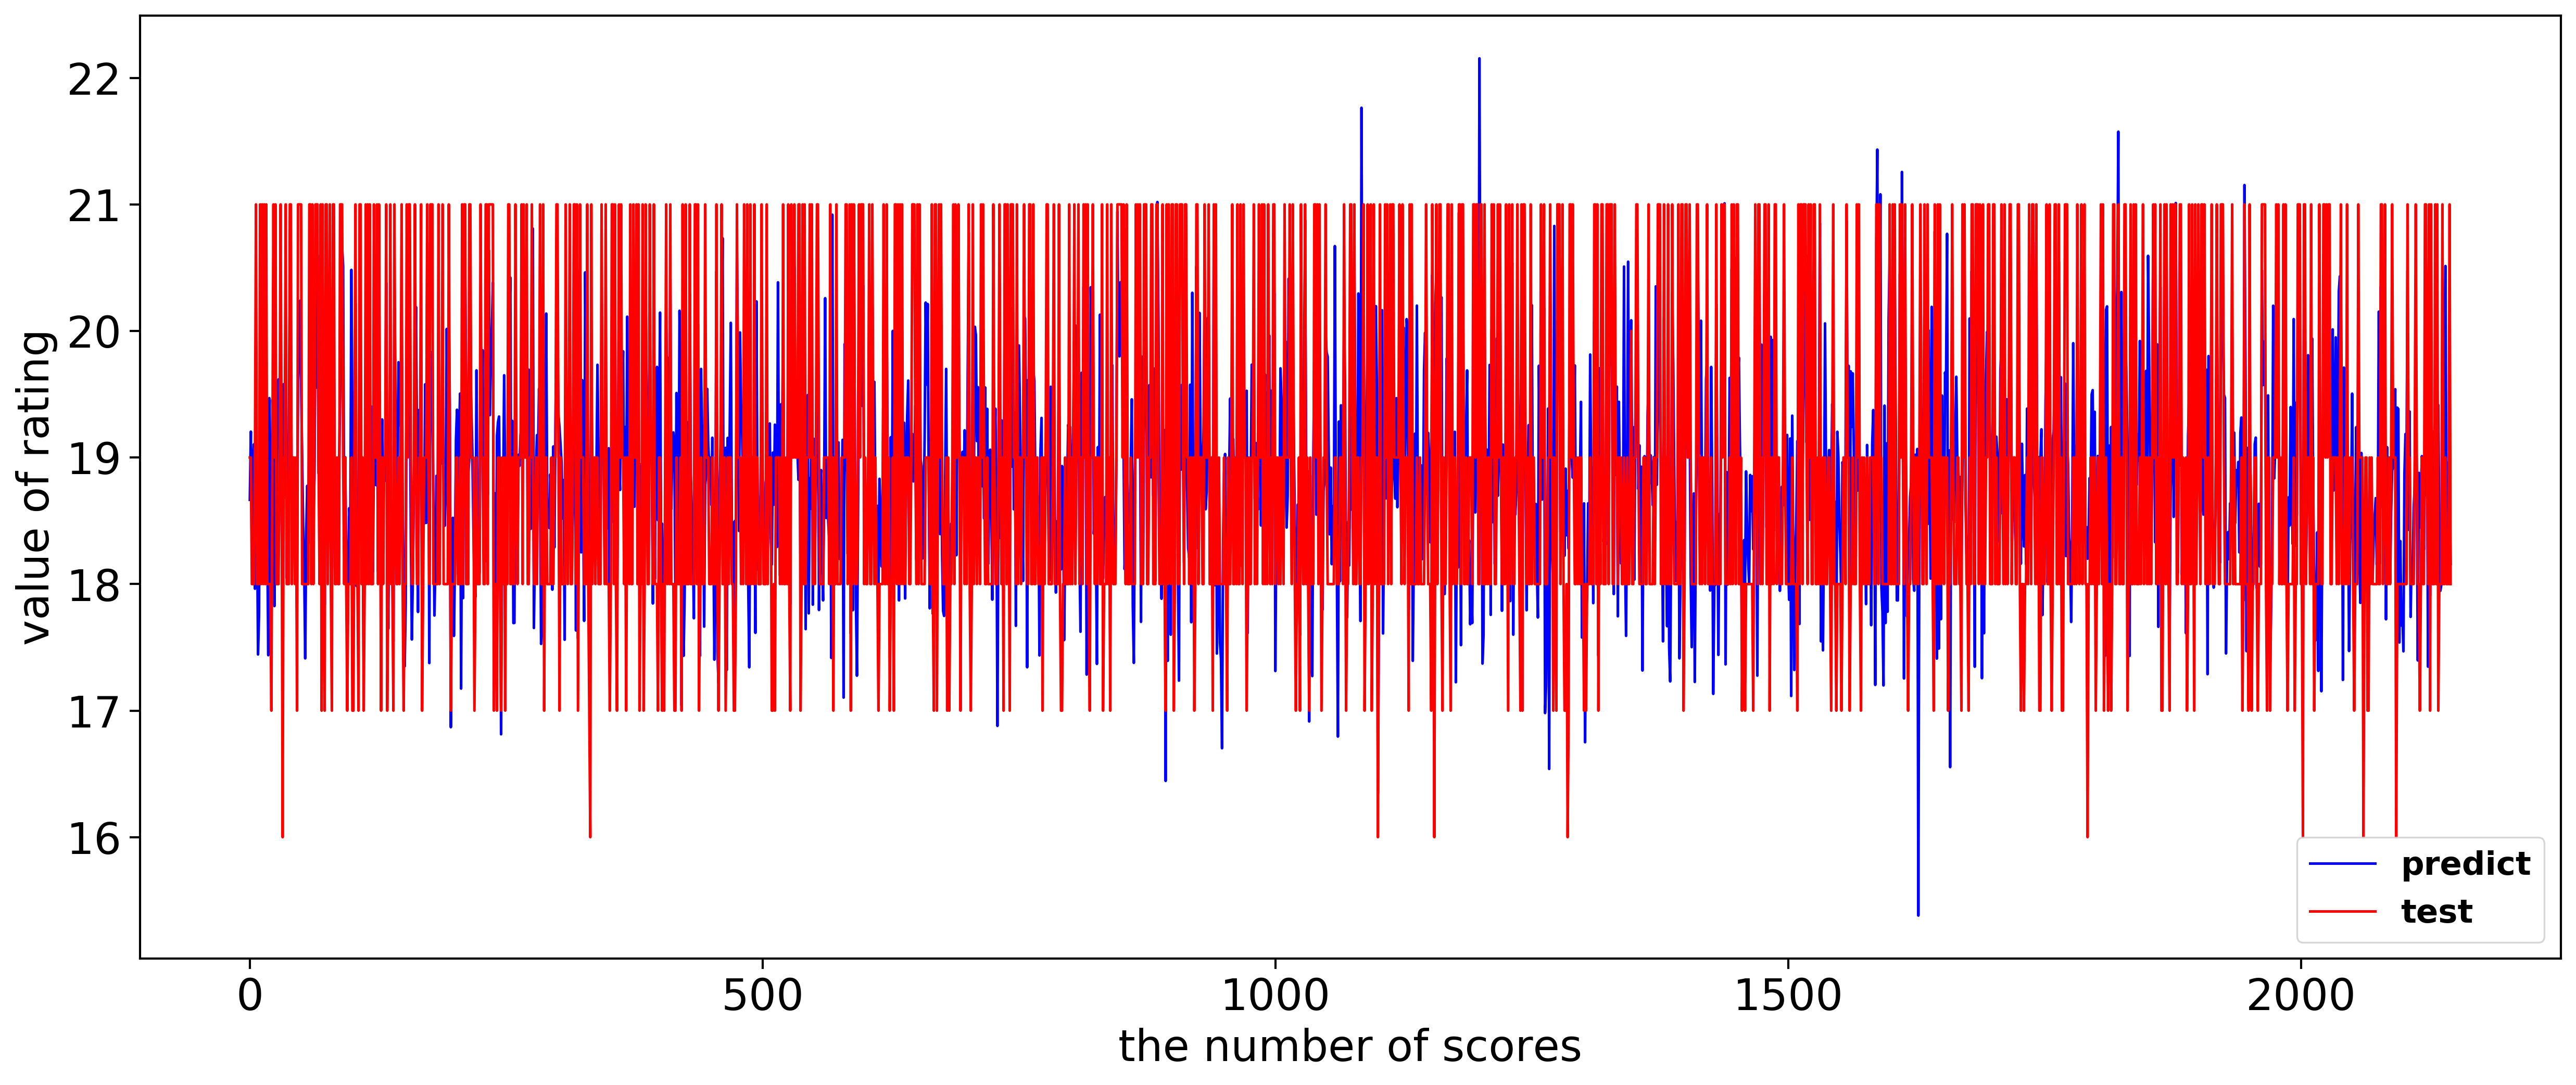

<Figure size 432x288 with 0 Axes>

In [65]:
# 仅选取相关性系数>0.1的指标+spread（16个），构造线性回归模型

print("3. 指标选取一的线性模型")
# 创建一个corr
selected_titles = ['ROA', 'ROS', 'ROIC', 'TAT','CAT','ITR','RTR','Debt','Flow','Quick','Cash','Interest','Profit','GDP','Budget','spread','scoring']
data_corr3 = df[selected_titles]
data_corr3 = pd.DataFrame(data_corr3, dtype=np.float)

X_train,X_test,Y_train,Y_test = train_test_split(data_corr3.ix[:,:16],data_corr3.scoring,train_size=.7)
 
print("原始数据特征:",data_corr3.ix[:,:16].shape,
      ",训练数据特征:",X_train.shape,
      ",测试数据特征:",X_test.shape)
 
print("原始数据标签:",data_corr3.scoring.shape,
      ",训练数据标签:",Y_train.shape,
      ",测试数据标签:",Y_test.shape)

# 建立初步的数据集模型之后将训练集中的特征值与标签值放入LinearRegression()模型中且使用fit函数进行训练
# 在模型训练完成之后会得到所对应的方程式（线性回归方程式）需要利用函数中的intercept_与coef_。
model_sele = LinearRegression()
model_sele.fit(X_train,Y_train)
a3  = model_sele.intercept_         #截距
b3  = model_sele.coef_              #回归系数
print("最佳拟合线:截距",a3)
print("回归系数：",b3)

# 4. 指标选取以后的模型评价
print("--Selected Factors模型评价--")
score_sele = model_sele.score(X_test,Y_test)
print(score_sele)
 
#对线性回归进行预测
Y_pred = model_sele.predict(X_test)
print(Y_pred)
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.show()

# 线性回归预测与测试对比
plt.figure(dpi=300,figsize=(20,8))
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_pred)),Y_test,'r',label="test")
plt.legend(loc='lower right', prop={"size":15,"weight":"black"}) # 显示图例
plt.tick_params(labelsize=20)  # 放大坐标轴刻度
plt.xlabel("the number of scores", fontsize=20)
plt.ylabel('value of rating', fontsize=20)
plt.show()
plt.savefig("../数据集/results/linear_regression_five.jpg")

## 6. 线性回归方程测试

In [66]:
# 写出线性回归表达式
def predict_regression(b,k_list,data_fra):
    i = 0
    sum = 0
    dataset = data_fra.values.tolist()
    for data in dataset:
        Y = a3
        score = data[16]
        data = data[:16]
        for k,t in zip(k_list,data):
            Y += k * t
        
        sum += abs(Y-score)
        data_fra.loc[i, 'predict'] = Y
        i += 1
    print("avg diff: ",sum/i)
    
    return data_fra

In [67]:
data_corr3['predict'] = 0                                               # 新增列
data_corr3 = predict_regression(a,b,data_corr)                       # 调用线性回归模型
data_corr3.to_excel("../数据集/linear_regression_predict_result.xlsx",index=0)   # 输出到tmp文件查看result

avg diff:  1688.3109430995935


## 7.回归优化

In [68]:
# 从⽂文件中读取原始数据
file_spread = '../数据集/债明细-生数据集.xlsx'           ###
df=pd.read_excel(file_spread)

In [69]:
# 按照指标分别删除0行
titles = ['ROE', 'ROA', 'ROS', 'ROIC', '总资产周转率','流动资产周转率','存货周转率','应收账款周转率','资产负债率','流动比率','速动比率','现金比率','利息保障倍数','销售收入增长率','净利润增长率','总资产增长率','经营活动现金流净额占比','投资活动现金流净额占比','筹资活动现金流净额占比','国内生产总值','居民消费价格指数增长率','一般预算收入','spread','scoring']
for t in titles:
    if t != '居民消费价格指数增长率':
        df = df[df[t]!=0]
        
# 存取筛选后的数据
ROE = df[titles[0]].values.tolist()   #盈利能力
ROA = df[titles[1]].values.tolist()
ROS = df[titles[2]].values.tolist() 
ROIC = df[titles[3]].values.tolist()

total_turnover = df[titles[4]].values.tolist()  #营运能力
flow_turnover = df[titles[5]].values.tolist()
inventory_turnover = df[titles[6]].values.tolist()
receive_turnover = df[titles[7]].values.tolist()

debt_r = df[titles[8]].values.tolist()   #负债情况
flow_r = df[titles[9]].values.tolist()
quick_r = df[titles[10]].values.tolist()
cash_r = df[titles[11]].values.tolist()
interest_mul = df[titles[12]].values.tolist()

sales = df[titles[13]].values.tolist()  #成长能力
profit = df[titles[14]].values.tolist()
assets = df[titles[15]].values.tolist()

business = df[titles[16]].values.tolist()   #现金流情况
invest = df[titles[17]].values.tolist()
finance = df[titles[18]].values.tolist() 

gdp = df[titles[19]].values.tolist()   #宏观
cpi = df[titles[20]].values.tolist()
budget = df[titles[21]].values.tolist()

# 列重命名
df.rename(columns={'总资产周转率':'TAT','流动资产周转率':'CAT','存货周转率':'ITR','应收账款周转率':'RTR', 
                   '资产负债率':'Debt','流动比率':'Flow','速动比率':'Quick','现金比率':'Cash','利息保障倍数':'Interest',
                   '销售收入增长率':'Sales','净利润增长率':'Profit','总资产增长率':'Assets',
                   '经营活动现金流净额占比':'Business','投资活动现金流净额占比':'Invest','筹资活动现金流净额占比':'Finance',
                   '国内生产总值':'GDP','居民消费价格指数增长率':'CPI','一般预算收入':'Budget'
                  }, inplace = True)

# 将所有指标分别相互相关性分析
data_corr = df[new_titles]
data_corr = pd.DataFrame(data_corr, dtype=np.float)

selected_titles = ['ROA', 'ROS', 'ROIC', 'TAT','CAT','ITR','RTR','Debt','Flow','Quick','Cash','Interest','Profit','GDP','Budget','spread','scoring']
data_corr3 = df[selected_titles]
data_corr3 = pd.DataFrame(data_corr3, dtype=np.float)

In [70]:
# 1. K-Means聚类数据准备
points = data_corr3.values[:,:-1]
labels = data_corr3.values[:,-1]
data = whiten(points)

# 2. 聚类实现
k = 15
max_iteration = 80
model = KMeans(n_clusters = k, max_iter = max_iteration).fit(data)
data_corr3['clustering'] = model.labels_     # 将labels作为列存入数据集中

In [71]:
# 线性回归方程结果计算
def regression_fomula(b,k_list,data_fra):
    i = 0
    sum = 0
    dataset = data_fra.values.tolist()
    for data in dataset:
        Y = a3
        score = data[16]
        data = data[:16]
        for k,t in zip(k_list,data):
            Y += k * t
    return Y

# （1）基于聚类的优化算法
def cluster_cata(test_list, data_corr444):
    # 测试函数 <类别，回归匹配，计算>
    target_category = model.predict([test_list])[0]
    regression_iteration = data_corr444.loc[data_corr444['clustering'] == target_category] # 选用聚类类中的数据集做回归建模
    
    # 训练模型
    X_train,X_test,Y_train,Y_test = train_test_split(regression_iteration.ix[:,:16],regression_iteration.scoring,train_size=.8)
    model_sele = LinearRegression().fit(X_train,Y_train)
    print("Score: ", model_sele.score(X_test, Y_test))    # 测试评分
    
    # 预测结果
    Y = regression_fomula(model_sele.intercept_, model_sele.coef_, data_corr444)
    
    #print(Y)
    return target_category

In [72]:
# cluster_cata测试运行
test_list = [2.5236, 29.0848, 2.9762, 0.0708, 0.1869, 1.1383, 0.5664, 2.715, 1.75, 1.55, 0.59, 1.28, 7.57, 1714.66, 40386705, 0.54]
target_category = cluster_cata(test_list, data_corr3) 

Score:  0.017169620987196543
